# Lecture 1

**Overview**
1. Groupby
    * Interactions
    * Simple Model
2. Boxplots
    * Quantiles
    * Whiskers
3. Histograms and Standard Deviation


**import libraries**

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # disable chained assignment warning
import seaborn as sns

## Explore the Titanic Data

In [2]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Contingency Tables as simple models

In [8]:
titanicSmall = titanic[['pclass','sex', 'survived']]
SurvByClassSex = titanicSmall.groupby(['pclass','sex'])

In [7]:
# People count (How many people were in each class (per sex))
peoplCount = SurvByClassSex.count()
peoplCount

survived
pclass sex             
1      female        94
       male         122
2      female        76
       male         108
3      female       144
       male         347

In [6]:
# survival count (How many people survived per class and sex)
survCount = SurvByClassSex.sum()
survCount

survived
pclass sex             
1      female        91
       male          45
2      female        70
       male          17
3      female        72
       male          47

In [9]:
# survival probability
survProb = SurvByClassSex.mean()
survProb

survived
pclass sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

In [13]:
# indexing multi-index pandas dataframes with .xs()
# female count only:
survCount.xs(key="female",level=1)

,survived
pclass,
1,91
2,70
3,72


### Task 1

We can regard this simple counting exercise as a "predictive model" where we "predict" the outcome based on bucketing the data and "classify" the Survival status by $S=1$, if $P_S(sex,pclass) \geq 0.5$ and $0$ otherwise.

1. Compute the **confusion matrix**, which is simply a $2x2$ contingency table of the predicted versus the actual outcomes. (Hint: Look at `pd.crosstab()`)
2. (**MC**) Compute the overall accuracy of this model in two ways: (i) directly from the confusion matrix and (ii) from the survival probabilities. (Hint: Look at `SurvByClassSex.count()` and `np.dot()`) 
    * **A** 0.878
    * **B** 0.887
    * **C** 0.787
    * **D** 0.778
    
3. Higher accuracy(="classification rate") clearly is equivalent to a lower "misclassification rate", which in machine learning is also called a *loss function*. Discuss 
    * whether misclassifying a female P1 passenger should count equally towards (reducing) the quality of the model as misclassifying a male P1 passenger.
    * whether there could be another loss function which would be more discriminatory.
    * what you would consider equally spaced "losses"
        * $0.3, 0.2, 0.1, 0$
        * $0.1, 0.01, 0.001, ...$

**Own solution**

In [55]:
#Check which combinations have a mean of 05 or higher
survProb[survProb["survived"]>=0.5]

,,survived
pclass,sex,
1,female,0.968085
2,female,0.921053
3,female,0.500000


In [30]:
# new column with prediction --> all females survive
titanicSmall["survived_pred"] = titanicSmall["sex"]=="female"
#confusion matrix between pred and actual 
conf_mat = pd.crosstab(titanicSmall["survived_pred"],titanicSmall["survived"])
conf_mat

survived,0,1
survived_pred,,
False,468,109
True,81,233


In [37]:
#Accuracy based on confMat
acc_1 = np.round((conf_mat.values[0,0]+conf_mat.values[1,1])/(titanicSmall.shape[0]),3)
print(acc_1)

#accuracy based on surv probabilities --> no accuracy of the model, just the survival rate? 
acc_2 = np.round(np.sum(peoplCount.values*survProb.values)/titanic.shape[0],3)
print(acc_2)

0.787
0.384


#### 1.1 Compute the confusion matrix

In [26]:
titanicSmall.loc[:,"surv_pred"] = titanic.loc[:,"sex"] == "female"
ConfMat = pd.crosstab(titanicSmall["surv_pred"], titanicSmall["survived"])
ConfMat

survived,0,1
surv_pred,,
False,468,109
True,81,233


#### 1.2 Compute the overall accuracy of this model in two ways:

In [57]:
# method 1: using ConfMat.values accuracy = [(TN + TP) / N]
N = np.sum(ConfMat.values)
acc1 = np.round( (ConfMat.values[0,0]+ConfMat.values[1,1]) / N, 3)

# method 2: using SurvProb and SurvByClassSex 
p = survProb.values
surv_rate = np.round( (peoplCount.values * p).sum() / N, 3) # --> Tis is only the survival rate not the accuracy?!
no_surv_pred = surv_rate*titanic.shape[0]
no_dead_pred = (1-surv_rate)*titanic.shape[0]
acc2 = (no_surv_pred+no_dead_pred)/N

print(f'acc method1: {acc1}\nacc method2: {acc2}')

acc method1: 0.787
acc method2: 1.0


#### 1.3 Higher accuracy(="classification rate") clearly is equivalent to a lower "misclassification rate", which in machine learning is also called a loss function. Discuss:

* whether misclassifying a female P1 passenger should count equally towards (reducing) the quality of the model as misclassifying a male P1 passenger.

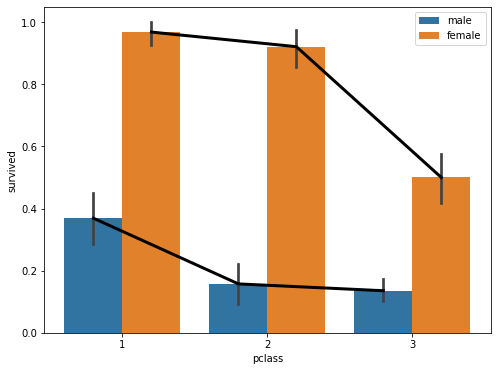

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=titanic,x="pclass",y="survived",hue="sex",ax=ax)

sns.lineplot(x=[0.2,1.2,2.2],y=survProb.xs(key="female",level=1).values.flatten(),
             ax=ax,color="k",linewidth=3,dashes=True)

sns.lineplot(x=[-0.2,0.8,1.8],y=survProb.xs(key="male",level=1).values.flatten()
             ,ax=ax,color="k",linewidth=3,dashes=True);

* whether there could be another loss function which would be more discriminatory.
    * *Log Loss*

* what you would consider equally spaced "losses"
    * $0.3, 0.2, 0.1, 0$
    * $0.1, 0.01, 0.001, ...$

### Task 2

We have seen a strong dependence of the *outcome* on the two "variables"/"features"/"regressors" *pclass* and *sex*.
The natural question is whether there could be more factors "correlated with"/"influencing"/"affecting" Survival.


1. Does the port of embarkment matter ?
    * (**MC**) What is the distribution (counts) of embarkment? (Hint: look at `pd.value_counts` )
        * **A** 168, 77, 644
        * **B** 158, 80, 636
        * **C** 170, 75, 639
        * **D** 164, 79, 667
    * (**MC**) What are the survival rates for *Southampton* as a function of `pclass`?
        * **A** 0.54, 0.42, 0.17
        * **B** 0.62, 0.39, 0.15
        * **C** 0.58, 0.46, 0.19
        * **D** 0.56, 0.37, 0.21
    * Do the survival rates "look" different from *Cherbourg* ?
    * How would you make sure that the observed differences are not due to chance ?
    
2. Does the *fare* paid matter ?
    * How would you quantify/visualize this ? 
    * What is the fundamental difference between the previous relationship of two variables ?
    * Have you heard of the terms *confounding* or *confounders* or *marginal dependence* versus *conditional dependence* ? 
    * Discuss dependencies among the features. Revisit the port of embarkment question in this light !
3. Does *age* matter ?
    * (**MC**) What is the survival rate for passengers below the age of 18?
        * **A** 0.47
        * **B** 0.74
        * **C** 0.54
        * **D** 0.45
    * (**MC**) What are the survival rates for passengers below the age of 18 stratified by pclass?
        * **A** 0.91, 0.87, 0.36
        * **B** 0.93, 0.88, 0.38
        * **C** 0.95, 0.93, 0.37
        * **D** 0.92, 0.91, 0.37
    * How would you make sure that the observed differences are not due to chance ?
    


#### 2.1 Does the port of embarkment matter ?

* What is the distribution (counts) of embarkment? (Hint: look at `pd.value_counts` )

In [58]:
titanic['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

* What are the survival rates for *Southampton* as a function of `pclass`?

In [59]:
titanic.groupby(['embarked', 'pclass']).mean()[['survived']].xs(key="S")

,survived
pclass,
1,0.582677
2,0.463415
3,0.189802


* Do the survival rates "look" different from *Cherbourg* ?

In [60]:
titanic.groupby(['embarked', 'pclass']).mean()[['survived']].xs(key="C")

,survived
pclass,
1,0.694118
2,0.529412
3,0.378788


* How would you make sure that the observed differences are not due to chance ?

**Answer PH:** Collect bootstrap samples of both distributions and compare the means ?

#### 2.2 Does the *fare* paid matter ?

**How would you quantify/visualize this?**

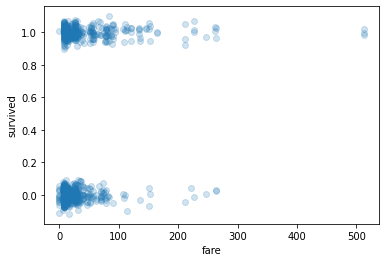

In [61]:
titanic['surv_Jitter'] = titanic['survived'] +  np.random.normal(0,0.035,N)

plt.scatter('fare', 'surv_Jitter', data = titanic, alpha = 0.2)
plt.xlabel("fare")
plt.ylabel("survived");

* What is the fundamental difference between the previous relationship of two variables ?

* Have you heard of the terms *confounding* or *confounders* or *marginal dependence* versus *conditional dependence* ?

* Discuss dependencies among the features. Revisit the port of embarkment question in this light !

3. Does *age* matter ?

* What is the survival rate for passengers below the age of 18?

In [13]:
titanic['Below18'] = titanic['age'] < 18
titanic.groupby('Below18').mean()[['survived']]

,survived
Below18,
False,0.361183
True,0.539823


**Visualization of `age` and `survived`**

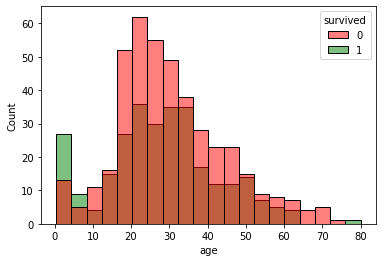

In [14]:
sns.histplot(data=titanic,x="age",hue="survived",palette=["red","green"]);

* What are the survival rates for passengers below the age of 18 stratified by pclass?

In [63]:
titanic['Below18'] = titanic['age'] < 18
titanic.groupby(['Below18','pclass']).mean()[['survived']].xs(key=True)

,survived
pclass,
1,0.916667
2,0.913043
3,0.371795


* How would you make sure that the observed differences are not due to chance ?

### Task 3

1. Create two random (normally distibuted) vectors x1 and x2 of length 500
2. Compute their individual stdevs
3. Create 2 new variables: (i) xs: the sum of x1 and x2 and (ii) xm: the mean of x1 and x2
4. Compute the stdevs of xs and xm

In [72]:
from numpy.random import randn 
np.random.seed(123)

x1=randn(500)
x2=randn(500)

print("stdv_x1:",np.std(x1),"stdv_x2:", np.std(x2))

xs=x1+x2
xm=(x1+x2)/2

print("stdv_xs:",np.std(xs),"stdv_xm:", np.std(xm))


stdv_x1: 1.0032028561568238 stdv_x2: 0.9983655274978708
stdv_xs: 1.4220961462939055 stdv_xm: 0.7110480731469527
